## Import Libraries

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [3]:
df = pd.read_csv("./Higher player.csv")

In [4]:
df.shape

(4840, 19)

In [5]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,3,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [6]:
df.drop(columns='Unnamed: 0' , inplace = True)
# df.drop(columns='name' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [7]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [8]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [9]:
# Accurecy types
df.dtypes

team                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

In [10]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [11]:
for i in categorical_col:
    print(df[i].value_counts())

team
Chelsea FC                      28
Manchester United               26
AZ Alkmaar                      26
Liverpool FC                    25
AC Monza                        25
                                ..
Club Estudiantes de La Plata     1
Defensa y Justicia               1
Club Athletico Paranaense        1
Club Atlético Tigre              1
Ulsan Hyundai                    1
Name: count, Length: 335, dtype: int64
position
Defender Centre-Back          955
Attack Centre-Forward         584
midfield-CentralMidfield      581
Goalkeeper                    442
midfield-DefensiveMidfield    432
Defender Right-Back           431
Defender Left-Back            399
midfield-AttackingMidfield    321
Attack-RightWinger            311
Attack-LeftWinger             285
midfield-RightMidfield         38
midfield-LeftMidfield          33
Attack-SecondStriker           25
Attack                          1
Defender                        1
midfield                        1
Name: count, dtype

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [12]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [13]:
categorical_col = ['team']

In [14]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [15]:
df.shape

(4840, 352)

In [16]:
encoder = LabelEncoder()
df['position'] = encoder.fit_transform(df['position'])  

#### 3. Feature selection

In [17]:
# sns.heatmap(df.corr(), annot=True);

In [18]:
correlation = df.corr()
correlation['position'].sort_values(ascending=False)

position          1.000000
yellow cards      0.135356
goals conceded    0.133292
clean sheets      0.129880
minutes played    0.064833
                    ...   
award            -0.044401
highest_value    -0.060210
height           -0.077749
assists          -0.192353
goals            -0.513394
Name: position, Length: 352, dtype: float64

In [19]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['position']) > threshold]['position'].index
selected_features

Index(['position', 'goals'], dtype='object')

In [20]:
df = df[selected_features]

#### 4. Prepare train and test data

In [21]:
# Prepare data
X = df.drop(['position'], axis=1)
y = df['position']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# # sacle the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [22]:
X.shape

(4840, 1)

## Buliding the Model

In [23]:
model = SVC()

In [24]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[0, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [25]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 2, 5, 10, 15, 20, 25], 'gamma': [1, 2, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [26]:
grid_search.best_params_

{'C': 2, 'gamma': 2, 'kernel': 'rbf'}

In [27]:
model = grid_search.best_estimator_

## Test the Model

In [28]:
# Predict and evaluate the model
y_pred = model.predict(X_test)

## Evaluating the Model 

In [29]:
# our benchmark model
base_model = round(df['position'].value_counts()[1]/df.shape[0]*100, 2)
base_model

12.07

1. Accuracy

In [35]:
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
print('Test accuracy' ,accuracy_test*100)

y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train accuracy' ,accuracy_train*100)


Test accuracy 39.0495867768595
Train accuracy 39.385330578512395


2. Precision

In [31]:
# Calculate Precision
precision_test = precision_score(y_test, y_pred, average='macro')
print(f"Test Precision: {precision_test:.2f}")

y_pred_train = model.predict(X_train)
precision_train = precision_score(y_train, y_pred_train,average='macro')
print(f"Train Precision: {precision_train:.2f}")

Test Precision: 0.12
Train Precision: 0.12


3. Recall

In [32]:
# Calculate Recall
recall_test = recall_score(y_test, y_pred, average='macro')
print(f"Test Recall: {recall_test:.2f}")

y_pred_train = model.predict(X_train)
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Train Recall: {recall_train:.2f}")

Test Recall: 0.22
Train Recall: 0.19


4. F1 Score

In [34]:
# Calculate F1 Score
f1_test = f1_score(y_test, y_pred, average='macro')
print(f"Test F1 Score: {f1_test:.2f}")

y_pred_train = model.predict(X_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"Train F1 Score: {f1_train:.2f}")

Test F1 Score: 0.16
Train F1 Score: 0.14


#### Predictions vs. Real Values

In [ ]:
predictions = model.predict(X_test)

In [ ]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

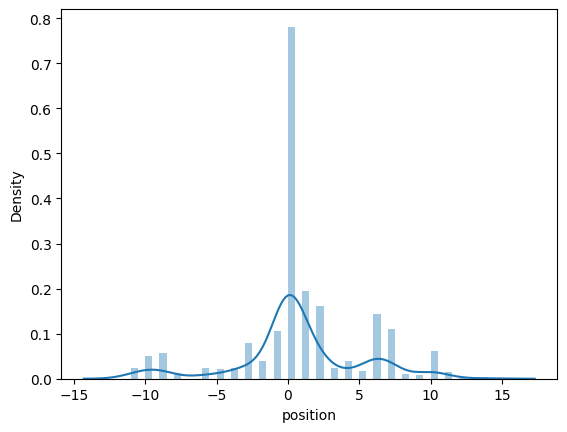

In [ ]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[121,   0,   0,   0,   1,   0,   0,   0,   5,  11,   0,   0,   0],
       [ 29,   0,   0,   0,   3,   0,   0,   0,   6,  19,   0,   0,   0],
       [ 28,   0,   0,   0,   5,   0,   0,   0,   6,  22,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 141,   0,   0,  33,   0,  11,   0,   0,   0],
       [  0,   0,   0,   0,  49,   0,   0,  19,   1,   9,   0,   0,   0],
       [  0,   0,   0,   0,  49,   0,   0,  22,   0,   7,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,  84,   0,   0,   0,   0,   0],
       [ 30,   0,   0,   0,   8,   0,   0,   0,   1,  29,   0,   0,   0],
       [  7,   0,   0,   0,  69,   0,   0,   6,   3,  31,   0,   0,   0],
       [  1,   0,   0,   0,  53,   0,   0,  19,   0,  13,   0,   0,   0],
       [  0,   0,   0,   0,   5,   0,   0,   0,   0,   1,   0,   0,   0],
       [  2,   0,   0,   0,   4,   0,   0,   0,   0,   2,   0,   0,   0]],
      dtype=int64)

In [ ]:
s